In [387]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Additional code for data generating processes

## Chapter 09

### Post-training earnings data (simple)

In [39]:
SAMPLE_SIZE = 200
MAX_AGE = 50

age = stats.halfnorm.rvs(loc=19, scale=10, size=SAMPLE_SIZE).astype(int)
age = np.where(age > MAX_AGE, np.random.choice(np.arange(20, MAX_AGE)), age)

took_a_course = stats.bernoulli(p=10/age).rvs().astype(bool)

earnings = 75000 + took_a_course * 10000 + age * 1000 + age**2 * 50 + np.random.randn(SAMPLE_SIZE) * 2000
earnings = earnings.round()

earnings = pd.DataFrame(dict(
    age=age,
    took_a_course=took_a_course,
    earnings=earnings
))

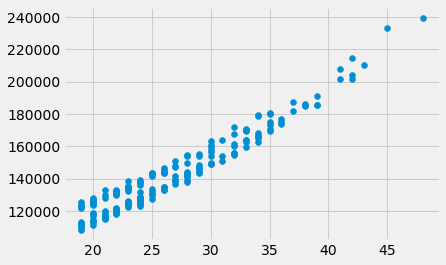

In [40]:
plt.scatter(earnings.age, earnings.earnings)

In [41]:
earnings.to_csv('data/ml_earnings.csv', index=False)

### Post-training earnings data (enhanced)

In [139]:
# Train set large
SAMPLE_SIZE = 5000
MAX_AGE = 50

age = stats.halfnorm.rvs(loc=19, scale=10, size=SAMPLE_SIZE).astype(int)
age = np.where(age > MAX_AGE, np.random.choice(np.arange(20, MAX_AGE)), age)

took_a_course = stats.bernoulli(p=10/age).rvs().astype(bool)
python_proficiency = np.random.uniform(0, 1, SAMPLE_SIZE)

noise = np.random.randn(SAMPLE_SIZE)

earnings = 75000 + took_a_course * 10000 + took_a_course * python_proficiency * 5000 + age * 1000 + age**2 * 50 + noise * 2000
earnings = earnings.round()

earnings = pd.DataFrame(dict(
    age=age,
    python_proficiency = python_proficiency,
    took_a_course=took_a_course,
    earnings=earnings
))

In [140]:
earnings.to_csv('data/ml_earnings_interaction_train.csv', index=False)

In [143]:
# Test set
SAMPLE_SIZE = 100
MAX_AGE = 50

age = stats.halfnorm.rvs(loc=19, scale=10, size=SAMPLE_SIZE).astype(int)
age = np.where(age > MAX_AGE, np.random.choice(np.arange(20, MAX_AGE)), age)

python_proficiency = np.random.uniform(0, 1, SAMPLE_SIZE)

noise = np.random.randn(SAMPLE_SIZE)

earnings_0 = (75000 + 0 * 10000 + 0 * python_proficiency * 5000 + age * 5000 + age**2 * 50 + noise * 2000).round()
earnings_1 = (75000 + 1 * 10000 + 1 * python_proficiency * 5000 + age * 5000 + age**2 * 50 + noise * 2000).round()
true_effect = earnings_1 - earnings_0

earnings_test = pd.DataFrame(dict(
    age=age,
    python_proficiency=python_proficiency,
    took_a_course=True,
    true_effect=true_effect
))

In [144]:
earnings_test.to_csv('data/ml_earnings_interaction_test.csv', index=False)

## Chapter 11

### Simulated data

In [467]:
SAMPLE_SIZE = 2000

def get_data_dgp_11(sample_size=1000, with_interaction=True):
    chi = np.random.chisquare(12, (sample_size, 5)) / 30
    norm = np.random.normal(0, 1, (sample_size, 5))
    binom = np.random.binomial(1, [.3, .5, .7, .12, .9], (sample_size, 5))
    gumbel = np.random.gumbel(-2, 1, (sample_size, 5)) / 6

    X = np.concatenate([chi, norm, binom, gumbel], axis=1)

    T0 = np.zeros(sample_size)
    T1 = np.ones(sample_size)
    
    noise = np.random.randn(sample_size)
    
    coefs = np.random.gumbel(0, 10, X.shape[1] + 1)
    
    if with_interaction:
        interaction_term = X[:, 0] + X[:, 7]
        y0 = (coefs * np.concatenate([(T0 * interaction_term).reshape(-1, 1), X], axis=1)).sum(axis=1) + noise
        y1 = (coefs * np.concatenate([(T1 * interaction_term).reshape(-1, 1), X], axis=1)).sum(axis=1) + noise
    else:
        interaction_term = 1
        y0 = (coefs * np.concatenate([
            T0.reshape(-1, 1), 
            X], 
            axis=1))\
        .sum(axis=1) + noise
        
        y1 = (coefs * np.concatenate([
            10 * np.exp(
                T1 + X[:, 7:12]\
                .sum(axis=1) / 1000).reshape(-1, 1), 
            X], 
            axis=1)).sum(axis=1) + noise
    
    return X, y0, y1, coefs


def filter_outcomes(y, t):
    result = np.zeros_like(t, dtype=float)  
    result[t == 0] = y[t == 0, 0]      
    result[t == 1] = y[t == 1, 1]    
    return result

#### No interaction

In [468]:
# No-interaction data
X, y0, y1, coefs = get_data_dgp_11(SAMPLE_SIZE, False)

# Generate treatments
T = np.random.binomial(1, 0.5, SAMPLE_SIZE)

# Train-test split
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(X, np.stack([y0, y1]).T, T, test_size=.1)

# Filter actual outcomes
y_train_actual = filter_outcomes(y_train, T_train)
y_test_actual = filter_outcomes(y_test, T_test)

# To DF & update cols
data_no_interaction_train = pd.DataFrame(
    np.concatenate(
        [
            X_train, 
            T_train.reshape(-1, 1), 
            y_train_actual.reshape(-1, 1)],
        axis=1
    )
)

data_no_interaction_train.columns = [f'x{i}' for i in range(20)] + ['treatment', 'outcome']


data_no_interaction_test = pd.DataFrame(
    np.concatenate(
        [
            X_test, 
            T_test.reshape(-1, 1), 
            (y_test[:, 1] - y_test[:, 0]).reshape(-1, 1)],
        axis=1
    )
)


data_no_interaction_test.columns = [f'x{i}' for i in range(20)] + ['treatment', 'true_effect']

# Store
data_no_interaction_train.to_csv('data/data_11_no_interaction_train.csv', index=False)
data_no_interaction_test.to_csv('data/data_11_no_interaction_test.csv', index=False)

In [469]:
y0, y1

(array([ 34.89751834,   8.61226375, -12.63565299, ...,   2.99937547,
         14.48281498,  32.13379007]),
 array([ -9.92622448, -36.0636879 , -57.4257863 , ..., -41.66052399,
        -30.30810687, -12.62264189]))

In [470]:
y1 - y0

array([-44.82374282, -44.67595165, -44.79013331, ..., -44.65989946,
       -44.79092185, -44.75643196])

#### With interaction

In [475]:
# No-interaction data
X, y0, y1, coefs = get_data_dgp_11(SAMPLE_SIZE, True)

# Generate treatments
T = np.random.binomial(1, 0.5, SAMPLE_SIZE)

# Train-test split
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(X, np.stack([y0, y1]).T, T, test_size=.1)

# Filter actual outcomes
y_train_actual = filter_outcomes(y_train, T_train)
y_test_actual = filter_outcomes(y_test, T_test)

# To DF & update cols
data_with_interaction_train = pd.DataFrame(
    np.concatenate(
        [
            X_train, 
            T_train.reshape(-1, 1), 
            y_train_actual.reshape(-1, 1)],
        axis=1
    )
)

data_with_interaction_train.columns = [f'x{i}' for i in range(20)] + ['treatment', 'outcome']


data_with_interaction_test = pd.DataFrame(
    np.concatenate(
        [
            X_test, 
            T_test.reshape(-1, 1), 
            (y_test[:, 1] - y_test[:, 0]).reshape(-1, 1)],
        axis=1
    )
)


data_with_interaction_test.columns = [f'x{i}' for i in range(20)] + ['treatment', 'true_effect']

# Store
data_with_interaction_train.to_csv('data/data_11_with_interaction_train.csv', index=False)
data_with_interaction_test.to_csv('data/data_11_with_interaction_test.csv', index=False)

In [474]:
y_test

array([[ 1.63371979e+01,  1.59045881e+01],
       [-3.06609145e+00, -1.84422244e+00],
       [-1.03359389e+01, -7.87196605e+00],
       [ 4.46875521e+00,  4.96359667e+00],
       [ 3.18576088e+01,  3.37932190e+01],
       [ 1.19932029e+01,  2.98884169e+00],
       [ 9.69525909e+00,  7.93796477e+00],
       [-7.38440149e+00, -8.60629373e+00],
       [ 2.41254919e+01,  1.35643255e+01],
       [ 1.97529380e+01,  1.63711534e+01],
       [ 2.43068304e+01,  2.23882172e+01],
       [-7.98322104e+00, -1.16848962e+01],
       [-2.54805435e+00, -9.10154055e+00],
       [-2.12343129e+01, -2.11751544e+01],
       [ 1.99864813e+00, -3.96052447e+00],
       [ 1.54031350e+01,  1.24315489e+01],
       [ 7.02887405e+00,  5.32079794e+00],
       [ 2.07225787e+00,  3.98963467e+00],
       [ 1.05768464e+01,  1.16281929e+01],
       [ 2.58577213e+01,  2.11922848e+01],
       [ 1.11960625e+01,  6.92346165e+00],
       [ 8.63504905e+00,  7.25811536e+00],
       [ 1.45579537e+01,  1.14446180e+01],
       [-1.

### Chapter 11 - NLP data

In [ ]:
df = pd.read_csv('data/manga.csv')  

In [ ]:
# Check gender indicator
df['gender_indicator'].unique()

In [ ]:
# Produce female avatar indicator
avatar = []

for i in df['gender_indicator']:
    if i:
        avatar.append(np.random.choice([0, 1], p=[.15, .85]))
    else:
        avatar.append(np.random.choice([0, 1], p=[.97, .03]))
        
df['female_avatar'] = avatar

# Sanity
df.groupby('gender_indicator')['female_avatar'].mean()

In [ ]:
# Produce stereotype indicator
df['love_indicator'] = df['text'].str.contains('love|roman').astype('int')

In [ ]:
# Add photo to the post at random
df['has_photo'] = np.random.choice([0, 1], size=df.shape[0])

In [ ]:
# Produce the outcome
noise = np.random.normal(0.01, .05, size=df.shape[0])
probas = .8 + 0.1 * df['love_indicator'] * 1.2 * (0.1 + df['has_photo']) - 0.7 * df['female_avatar'] + noise
probas = np.clip(probas, 0, 1)

upvote = []

for p in probas:
    upvote_ = np.random.choice([0, 1], p=[1 - p, p])
    upvote.append(upvote_)
    
df['upvote'] = likes

In [ ]:
df.drop(['gender_indicator', 'topic', 'love_indicator', 'author'], axis=1).to_csv('data/manga_processed.csv', index=False)